In [29]:
import numpy as np
import geopandas as gpd
import os
import zipfile as zf
import shapefile
from shapely.geometry import shape
import gzip 
import urllib.request
import xarray as xr
import io
import pandas as pd
import datetime as dt
from datetime import datetime
import arch
import os
from statsmodels.tsa import stattools, arima 
import pmdarima as pm
os.getcwd()
os.listdir()

['.ipynb_checkpoints',
 'Data Reading and Descriptives.ipynb',
 'Geo-Pandas experiment with GARCH experiment.ipynb',
 'TM_WORLD_BORDERS-0.3.zip']

In [2]:
zp = zf.ZipFile('TM_WORLD_BORDERS-0.3.zip')
files_to_read = [y for y in zp.namelist() for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]
dummy = zp.read(files_to_read[0])
dbf_file, prj_file, shp_file, shx_file = [zp.open(filename) for filename in files_to_read]
r = shapefile.Reader(shp = shp_file, shx = shx_file, dbf = dbf_file, encoding='windows-1252')
attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]
for row in r.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names, row.record)))

In [3]:
gdf = gpd.GeoDataFrame(data = attributes, geometry = geometry)

In [4]:
gdf

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ..."
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ..."
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39..."
3,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.43621 41.02107, 19.45055 41.06000..."
4,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40..."
...,...,...,...,...,...,...,...,...,...,...,...,...
241,TB,BL,BLM,652,Saint Barthelemy,0,0,19,29,-63.043,18.040,"POLYGON ((-63.02834 18.01555, -63.03334 18.015..."
242,GK,GG,GGY,831,Guernsey,0,0,150,154,-2.576,49.459,"POLYGON ((-2.59083 49.42249, -2.59722 49.42249..."
243,JE,JE,JEY,832,Jersey,0,0,150,154,-2.129,49.219,"POLYGON ((-2.01500 49.21416, -2.02111 49.17722..."
244,SX,GS,SGS,239,South Georgia South Sandwich Islands,0,0,0,0,-36.891,-54.209,"MULTIPOLYGON (((-27.32584 -59.42722, -27.29806..."


In [5]:
url = "https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz"
req = urllib.request.Request(url)
with gzip.open(urllib.request.urlopen(req)) as resp:
    xr_df = xr.open_dataset(io.BytesIO(resp.read()))
df = xr_df.to_dataframe()
df2 = df.reset_index()

In [6]:
gdf2 = df2[df2['time'].dt.year > 2000]
del df2
del df
gdf2 = gpd.GeoDataFrame(
    gdf2, geometry=gpd.points_from_xy(gdf2.lon, gdf2.lat))

In [7]:
import gc
gc.collect()

20

In [8]:
gdf2

,lat,lon,nv,time,time_bnds,tempanomaly,geometry
1452,-89.0,-179.0,0,2001-01-15,2001-01-01,-0.45,POINT (-179.00000 -89.00000)
1453,-89.0,-179.0,0,2001-02-15,2001-02-01,1.00,POINT (-179.00000 -89.00000)
1454,-89.0,-179.0,0,2001-03-15,2001-03-01,-1.48,POINT (-179.00000 -89.00000)
1455,-89.0,-179.0,0,2001-04-15,2001-04-01,-2.40,POINT (-179.00000 -89.00000)
1456,-89.0,-179.0,0,2001-05-15,2001-05-01,-0.57,POINT (-179.00000 -89.00000)
...,...,...,...,...,...,...,...
54950395,89.0,179.0,1,2020-12-15,2021-01-01,NaN,POINT (179.00000 89.00000)
54950396,89.0,179.0,1,2021-01-15,2021-02-01,NaN,POINT (179.00000 89.00000)
54950397,89.0,179.0,1,2021-02-15,2021-03-01,NaN,POINT (179.00000 89.00000)
54950398,89.0,179.0,1,2021-03-15,2021-04-01,NaN,POINT (179.00000 89.00000)


In [9]:
final_gdf = gpd.sjoin(gdf, gdf2, how="inner")

In [10]:
gdf_US = final_gdf[final_gdf['ISO3'] == 'USA']
del final_gdf
del gdf2
del gdf
gc.collect()

731

In [11]:
gdf_US

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,index_right,lat,lon,nv,time,time_bnds,tempanomaly
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",42272653,49.0,-95.0,0,2009-02-15,2009-02-01,1.04
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",42272654,49.0,-95.0,0,2009-03-15,2009-03-01,0.06
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",41677446,47.0,-87.0,1,2016-07-15,2016-08-01,1.21
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",41677445,47.0,-87.0,1,2016-06-15,2016-07-01,0.85
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",41677444,47.0,-87.0,1,2016-05-15,2016-06-01,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",37355994,33.0,-115.0,1,2012-11-15,2012-12-01,1.89
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",37355993,33.0,-115.0,1,2012-10-15,2012-11-01,1.34
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",37355992,33.0,-115.0,1,2012-09-15,2012-10-01,2.40
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",37355991,33.0,-115.0,1,2012-08-15,2012-09-01,2.06


In [18]:
gdf_US[(gdf_US['tempanomaly'] >= 5)].time_bnds.min()

Timestamp('2001-01-01 00:00:00')

C:\Users\jara_\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


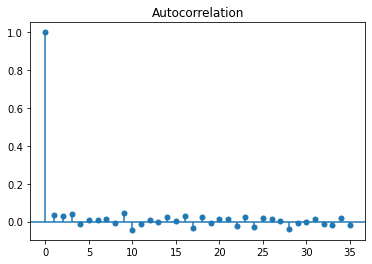

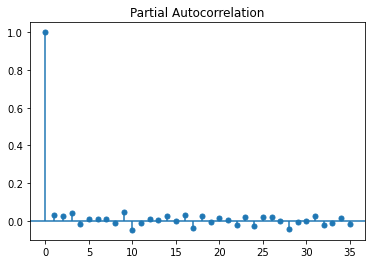

In [24]:
path = os.getcwd()
path = path.replace('\\Experimental Notebooks', '')
path = path + '\\Data'
files = os.listdir(path)
returns_df_path = [x for x in files if 'returns' in x]
returns_df = pd.read_csv(path + '\\' + returns_df_path[0])
returns_df['Date'] = pd.to_datetime(returns_df['Date'])
returns_df = returns_df.sort_values(by = 'Date')
returns_df_train = returns_df[(returns_df['Date'].dt.year >= 2001) & (returns_df['Date'].dt.year < 2021)]
pm.arima.ndiffs(returns_df['Return'])
pm.arima.nsdiffs(returns_df['Return'], m = 7)
diff_series = returns_df.Return.diff()
pm.plot_acf(diff_series.dropna())
pm.plot_pacf(diff_series.dropna())

In [27]:
arima_component = pm.auto_arima(returns_df_train['Return'], max_p = 5, 
                                max_q = 5, m =7, max_P = 5, 
                                max_Q = 5, max_D = 2,
                                seasonal = True, trace = False)
arima_component.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2435
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -11651.214
Date:                Thu, 20 May 2021   AIC                          23310.429
Time:                        11:58:05   BIC                          23333.618
Sample:                             0   HQIC                         23318.859
                               - 2435                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2316      0.194      1.193      0.233      -0.149       0.612
ar.L1          0.7627      0.129      5.915      0.000       0.510       1.015
ma.L1         -0.7304      0.137     -5.314      0.000      -1.000      -0.461
sigma2       842.2959     14.025     60.058      0.000     814.808     869.784
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2023.47
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               4.00   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\jara_\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


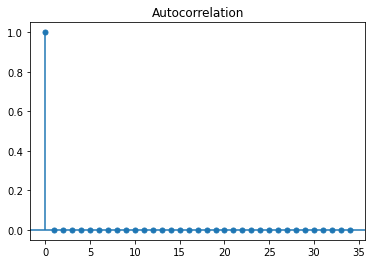

C:\Users\jara_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='Date'>

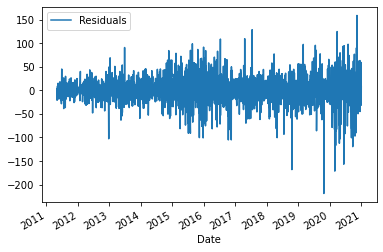

In [32]:
residuals = arima_component.resid()
pm.plot_acf(np.square(residuals))
returns_df_train['Residuals'] = residuals.tolist()
returns_resid = returns_df_train.iloc[1:]
returns_resid.plot(x = 'Date', y = 'Residuals')

In [50]:
df_US_hw = gdf_US[(gdf_US['tempanomaly'] >= 5)].filter(regex = 'tempanomaly|time_bnds|time')
df_US_hw = pd.DataFrame(df_US_hw)
df_US_hw = df_US_hw.set_index(['time', 'time_bnds'])
df_US_hw = df_US_hw.loc[~df_US_hw.index.duplicated(keep = 'last')]
df_US_hw = df_US_hw.reset_index()

In [91]:
date_frames = list()
for i in range(len(df_US_hw)):
    if df_US_hw['time'][i] > df_US_hw['time_bnds'][i]:
        date_frames.append(pd.DataFrame(index = pd.date_range(df_US_hw['time_bnds'][i], df_US_hw['time'][i], freq = 'd')))
    else:
        date_frames.append(pd.DataFrame(index = pd.date_range(df_US_hw['time'][i], df_US_hw['time_bnds'][i], freq = 'd')))

heatwave_df = pd.concat(date_frames)
heatwave_df['heatwave'] = 1
heatwave_df = heatwave_df.reset_index()

In [93]:
heatwave_df.columns = ['Date', 'heatwave']

In [101]:
returns_resid = returns_resid.merge(heatwave_df, on = 'Date', how = 'left')


In [107]:
returns_resid.loc[returns_resid['heatwave'].isna(), 'heatwave'] = 0
returns_resid.head()

,Date,Return,Residuals,heatwave
0,2011-05-03,1297.992102,-0.525180,0.0
1,2011-05-04,1301.637699,2.659242,0.0
2,2011-05-05,1281.456087,-21.253844,0.0
3,2011-05-06,1284.203218,2.394539,0.0
4,2011-05-09,1278.134417,-6.647208,0.0


In [109]:
arch_ext_reg = arch.arch_model(returns_resid['Residuals'], mean = 'ARX',
                               x = returns_resid['heatwave'], vol = 'Garch', p = 1, q = 1)

C:\Users\jara_\Anaconda3\lib\site-packages\arch\univariate\mean.py:448: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self._x = self._x[:, None]


In [110]:
arch_ext_reg.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 18560.96366854084
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11753.5004993427
Iteration:      3,   Func. Count:     22,   Neg. LLF: 11723.04397764981
Iteration:      4,   Func. Count:     29,   Neg. LLF: 471087259.9742111
Iteration:      5,   Func. Count:     36,   Neg. LLF: 12633.63393745686
Iteration:      6,   Func. Count:     43,   Neg. LLF: 11744.070994269316
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11776.501980625768
Iteration:      8,   Func. Count:     57,   Neg. LLF: 11711.367369037478
Iteration:      9,   Func. Count:     64,   Neg. LLF: 11920.228217746288
Iteration:     10,   Func. Count:     71,   Neg. LLF: 11706.434432184049
Iteration:     11,   Func. Count:     78,   Neg. LLF: 11700.467495927349
Iteration:     12,   Func. Count:     84,   Neg. LLF: 11700.361965180637
Iteration:     13,   Func. Count:     90,   Neg. LLF: 11700.342455812552
Iteration:     14,   Func. Count:     96,   Neg. LLF: 117

                          AR-X - GARCH Model Results                          
Dep. Variable:              Residuals   R-squared:                      -0.000
Mean Model:                      AR-X   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -11700.3
Distribution:                  Normal   AIC:                           23410.7
Method:            Maximum Likelihood   BIC:                           23439.8
                                        No. Observations:                 2496
Date:                Thu, May 20 2021   Df Residuals:                     2491
Time:                        23:16:44   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          0.2899      0.624      0.465      0.642 [ -0.932,  1.51